In [2]:
from ekpy import analysis
import numpy as np
import scipy.integrate as it
from scipy.signal import find_peaks, savgol_filter, peak_widths
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
data = pd.read_csv(r"C:\Users\geofr\Desktop\Research\Data\FE\PUND\Radiant\JJ\V2\400 PMA\E3w.txt", skiprows=51, skipfooter=19, encoding='mbcs')
data

C:\Users\geofr\AppData\Local\Temp\ipykernel_4796\802335735.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(r"C:\Users\geofr\Desktop\Research\Data\FE\PUND\Radiant\JJ\V2\400 PMA\E3w.txt", skiprows=51, skipfooter=19, encoding='mbcs')


,Point,Time (ms),Drive Voltage,Measured Polarization (µC/cm2),Capacitance (µF),Normalized Capacitance (µF/cm2),Dielectric Constant,Instantaneous Current (mA)
0,1,0.0000,-0.0240,3.125139,15.234374,152343.744982,5.161546,-0.009973
1,2,0.0005,-0.0459,3.075276,15.234374,152343.744982,5.161546,-0.009973
2,3,0.0010,-0.0648,2.997522,23.755296,237552.958277,8.048512,-0.015551
3,4,0.0015,-0.0829,2.893569,31.759798,317597.976827,10.760511,-0.020791
4,5,0.0020,-0.1041,2.774826,36.278468,362784.680847,12.291478,-0.023749
...,...,...,...,...,...,...,...,...
9070,9071,4.5350,-0.1024,-34.467808,72.944251,729442.507753,24.714181,0.047751
9071,9072,4.5355,-0.0813,-34.226519,73.718880,737188.799871,24.976633,0.048258
9072,9073,4.5360,-0.0626,-33.967059,79.270389,792703.893381,26.857535,0.051892
9073,9074,4.5365,-0.0439,-33.718586,75.913663,759136.627538,25.720245,0.049695


In [13]:
voltage_arr = data['Drive Voltage'].to_numpy()
polaraization_arr = data['Measured Polarization (µC/cm2)'].to_numpy()
time_arr = data['Time (ms)'].to_numpy()
current_arr = data['Instantaneous Current (mA)'].to_numpy()

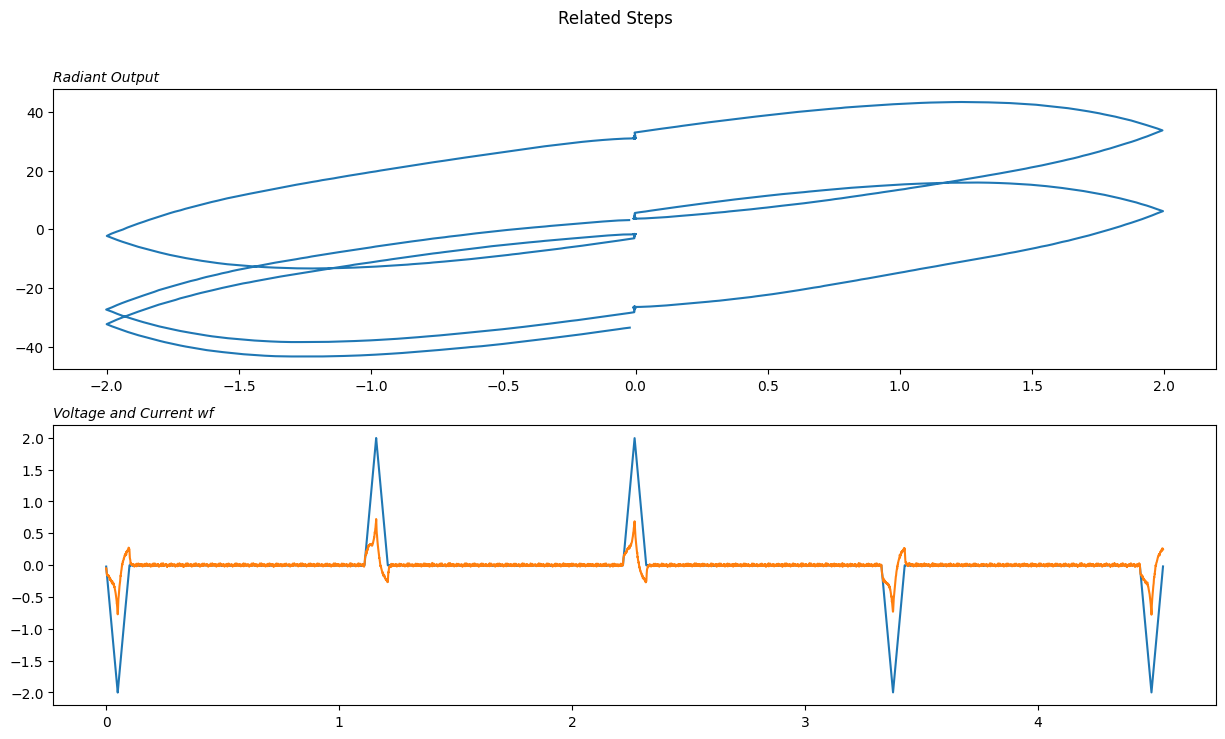

In [14]:
fig, ax = plt.subplots(2,1, figsize=(15,8))
fig.suptitle('Related Steps')
ax[0].set_title('Radiant Output', loc='left', fontstyle='oblique', fontsize='medium')
ax[0].plot(voltage_arr, polaraization_arr)
ax[1].set_title('Voltage and Current wf', loc='left', fontstyle='oblique', fontsize='medium')
ax[1].plot(time_arr, voltage_arr)
ax[1].plot(time_arr, 5*current_arr)


SO now basically we want to take the first pulse and subtract hte second pulse. so we need to find peaks! (actually its start and end of the each pulse train)
seems easier to just hard code it since we know the waveform

Text(0.5, 1.0, 'Sanity check to ensure we are plotting correct parts')

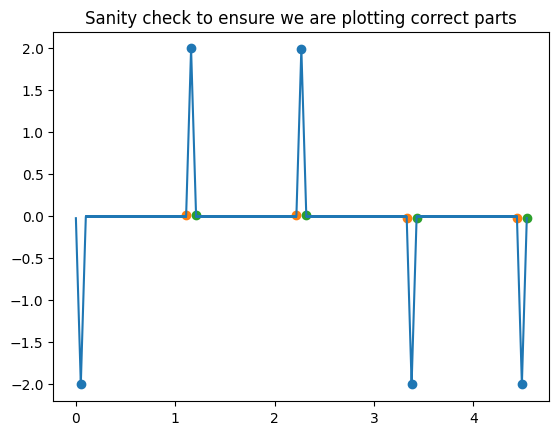

In [15]:
def find_peaks_troughs_index(arr):
    arr_normalized = 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1
    peaks, _ = find_peaks(arr_normalized, height=0.8)
    troughs, _ = find_peaks(-1*arr_normalized, height=0.8)
    all_peaks = np.concatenate((peaks, troughs), axis=0)
    return all_peaks

my_peaks = np.sort(find_peaks_troughs_index(voltage_arr))
#Get the start and end of each pulse sequence
start_arr = my_peaks - 99
end_arr = my_peaks + 99
valid_start = start_arr[1:] #this will have to change if i done have the first negative pulse
valid_end = end_arr[1:]
start_pos = valid_start[0]
end_pos = valid_end[0]
start_pos_residual = valid_start[1]
end_pos_residual = valid_end[1]
start_neg = valid_start[2]
end_neg = valid_end[2]
start_neg_residual = valid_start[3]
end_neg_residual = valid_end[3]
#sanity check plot these points
plt.plot(time_arr, voltage_arr)
plt.scatter(time_arr[my_peaks], voltage_arr[my_peaks])
plt.scatter(time_arr[valid_start], voltage_arr[valid_start])
plt.scatter(time_arr[valid_end], voltage_arr[valid_end])
plt.title("Sanity check to ensure we are plotting correct parts")


In [16]:
#subtract I1-I2 and I3- I4

i1_sub_i2 = current_arr[start_pos:end_pos] - current_arr[start_pos_residual:end_pos_residual]
i3_sub_i4 = current_arr[start_neg:end_neg] - current_arr[start_neg_residual:end_neg_residual]
#now plot new current waveform and then we need to integrate etc
#first get new voltage array and combine the current arrays
modified_curr_arr = np.concatenate([i1_sub_i2, i3_sub_i4])
modified_time_arr = np.concatenate([time_arr[start_pos:end_pos], time_arr[start_neg:end_neg]])
modified_voltage_arr = np.concatenate([voltage_arr[start_pos:end_pos], voltage_arr[start_neg:end_neg]])
#now integrate
wfm_q = it.cumulative_trapezoid(modified_curr_arr, modified_time_arr, initial=0) 


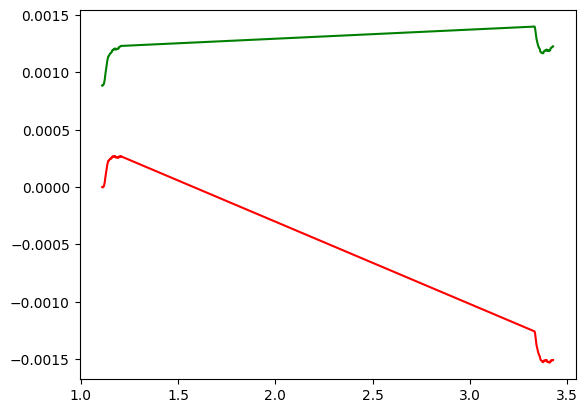

In [17]:
plt.plot(modified_time_arr, wfm_q, color='red')
#need to drift correct?
slope = (wfm_q[300] - wfm_q[100])/(modified_time_arr[300]-modified_time_arr[100])
wfm_q_drift_corrected = []
for i in range(len(wfm_q)):
    wfm_q_drift_corrected.append(wfm_q[i]-(slope*modified_time_arr[i]))
plt.plot(modified_time_arr, wfm_q_drift_corrected, color='green')

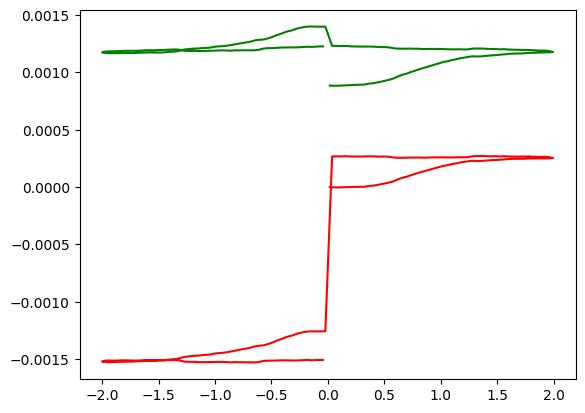

In [18]:
plt.plot(modified_voltage_arr, wfm_q, color='red')
plt.plot(modified_voltage_arr, wfm_q_drift_corrected, color='green')

In [19]:
#new strat just manually align the two
#now for the left hand side which is the 2nd half of the array
one = wfm_q_drift_corrected[:int(len(wfm_q_drift_corrected)/2)] 
two = wfm_q_drift_corrected[int(len(wfm_q_drift_corrected)/2):] 
offset = np.array(two).max() - np.array(two).min()
pieced_wfm_q = np.concatenate([one + offset, two]) 

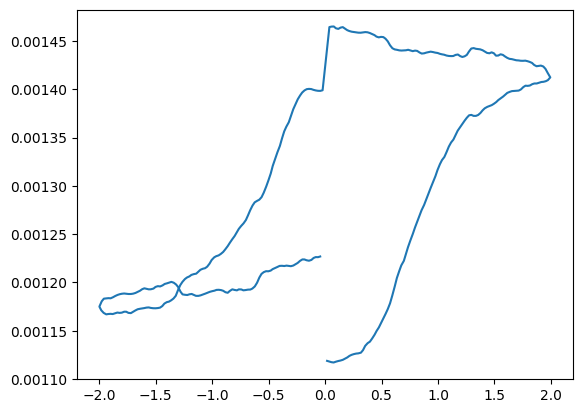

In [20]:
plt.plot(modified_voltage_arr, pieced_wfm_q)
##plt.plot(modified_voltage_arr[:int(len(wfm_q_drift_corrected)/2)], one, color='green')
#plt.plot(modified_voltage_arr[int(len(wfm_q_drift_corrected)/2):], two)